Our goal is to determine whether the text message is spam or ham.

Here we have a set of SMS Messages in English of 5,574 Messages,tagged according being ham and spam.

The files contain one meassage per line. Each line is composed by two columns: class (spam or ham) and raw message.

Using these ham/spam examples, we'll train a machine learning model to learn to discriminate between ham/spam automatically. Then, with a trained model, we'll be able to classify arbitrary unlabeled messages as ham or spam.


## Data Analysis

#### importing required Libraries

In [1]:
import pandas as pd                                    #for reading dataset
import matplotlib.pyplot as plt                        #for plotting 
import numpy as np
import seaborn as sns                                  #for graphical representation
%matplotlib inline

# Warnings
import warnings
warnings.filterwarnings('ignore')                     #for ignoring warning

# Text Preprocessing
import nltk                                           #importing nltk for removing stopwords ,wordnet(for meaning,anonyms,sytonyms of word)  
nltk.download("stopwords")
nltk.download('wordnet')
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize               #tokenizing the words
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

from wordcloud import WordCloud                       #for making wordcloud

from sklearn.model_selection import train_test_split                        #for spliting data into train and test
from sklearn.feature_extraction.text import TfidfTransformer                #for counting number words
from sklearn.feature_extraction.text import TfidfVectorizer                 #for vectorizing 
from sklearn.feature_extraction.text import CountVectorizer                 #for collection of matrix into token counts
from sklearn.preprocessing import LabelEncoder                              #for labeling the classes
from sklearn.model_selection import cross_val_score                         #for analysing cross_validation_score
from sklearn.metrics import fbeta_score                                     #for getting mean of precision and recall                       
from sklearn.naive_bayes import MultinomialNB                               #using multinomial Classifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix        #for computing various parameters

from textblob import TextBlob                                               #for processig texual data
import pickle                                                               #pickle module implements binary protocols for serializing and de-serializing

[nltk_data] Downloading package stopwords to /home/nikhil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nikhil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#reading the data
df = pd.read_csv("/home/nikhil/Animesh/SMS_Spam_Detector/spam.csv", encoding = "latin-1")      #encoding our dataset

In [4]:
#we can check first few rows
df.head()

,class,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


After reading the dataset we can see two classes here one is spam and another is ham.

As we can see there are unnecessary columns (Unnamed:2,Unnamed:3,Unnamed:4),so we are Droping those columns.

In [5]:

df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis = 1)
df = df.rename(columns={"class":"label"})                       #Here we are renaming column class to label for understanding purpose 

In [6]:
#after removing the unnecessary coulmns 
#we are again checking the rows 
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
#we can also see the information to confirm everything is alright
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label      5572 non-null object
message    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


In [8]:
#now we check the statistics of the important data that we need in future for our model
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

we can see that some of the messages are repeated(unique).
so no we check the most repeatative data.

In [9]:
#checking top-10 spam/ham messages
topMessages = df.groupby('message')['label'].agg([len, np.max]).sort_values(by = "len", ascending = False).head(n = 10)
display(topMessages)

,len,amax
message,,
"Sorry, I'll call later",30,ham
I cant pick the phone right now. Pls send a message,12,ham
Ok...,10,ham
Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..,4,ham
"Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.",4,ham
Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed å£1000 cash or å£5000 prize!,4,spam
Okie,4,ham
"Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD.Send this to Ten special people &amp; u c miracle tomorrow, do it,pls,pls do it...",4,ham
"7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd Ur Nature 2nd Ur SMS and 1st \Ur Lovely Friendship\""... good morning dear""",4,ham


from this state we can see that 
people seems busy  "Sorry, I'll call later"  tops the ham messages ,
"I cant pick the phone right now. Pls send a message"  picks 2nd top with 12 ham ,
and then there are numbers 'ok...,ok.,okie 

In [10]:
#we can find the length of the message 
#so adding a new column in dataframe for determining the length of every message

df['length'] = df['message'].map(lambda text : len(text))
print(df.head())

  label                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61


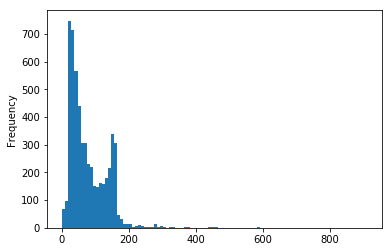

In [11]:
#now by plotting the histrogram we can have a better visualization
df.length.plot(bins = 100 , kind = 'hist')

We can see here maximum messages contains number of words in the range of [0, 200].

In [12]:
#checking the statstics of the lenght of message
df.length.describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

Here we can see that average length of the message is `80` and where minimum length is `2` and maximum legth is `910`

now we can show the difference between `ham` and `spam` by ploting them

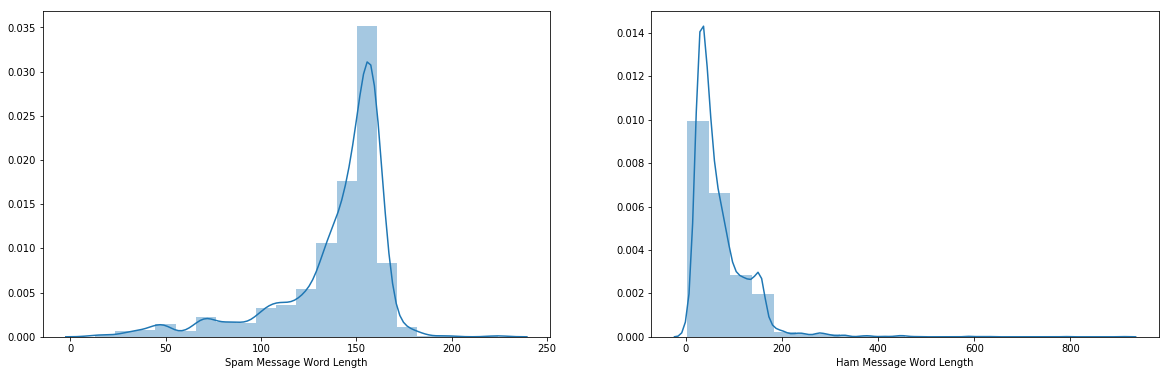

In [14]:
f , ax = plt.subplots(1, 2 , figsize = (20,6))
sns.distplot(df[df['label'] == 'spam']['length'],bins = 20 , ax = ax[0] )
ax[0].set_xlabel('Spam Message Word Length')

sns.distplot(df[df['label'] == 'ham']['length'],bins = 20 , ax = ax[1] )
ax[1].set_xlabel('Ham Message Word Length')

plt.show()

A lot of messages are actually not spam. About 87% of our dataset consists of normal messages.

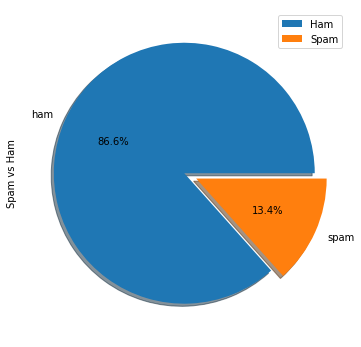

In [15]:
#now check the percentage of the distrubution of Ham message and Spam message .

df["label"].value_counts().plot(kind = 'pie', explode = [0,0.1], figsize = (6,6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

Here we are individually analyse the spam messages and ham messages.
We are lowercasing the messages ,tokenizing them and removing stopwords for reducing unnecessary computation.

In [16]:
# individual study of Ham and Spam message 

spam_messages = df[df["label"] == "spam"]["message"]
ham_messages = df[df["label"] == "ham"]["message"]

spam_words = []
ham_words = []

def extractSpamWords(spamMessages):
    global spam_words
    words = [word.lower() for word in word_tokenize(spamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    spam_words = spam_words + words
    
def extractHamWords(hamMessages):
    global ham_words
    words = [word.lower() for word in word_tokenize(hamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    ham_words = ham_words + words

spam_messages.apply(extractSpamWords)
ham_messages.apply(extractHamWords)

0       None
1       None
3       None
4       None
6       None
7       None
10      None
13      None
14      None
16      None
17      None
18      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
30      None
31      None
32      None
33      None
35      None
36      None
37      None
38      None
        ... 
5538    None
5539    None
5541    None
5542    None
5543    None
5544    None
5545    None
5546    None
5548    None
5549    None
5550    None
5551    None
5552    None
5553    None
5554    None
5555    None
5556    None
5557    None
5558    None
5559    None
5560    None
5561    None
5562    None
5563    None
5564    None
5565    None
5568    None
5569    None
5570    None
5571    None
Name: message, Length: 4825, dtype: object

We are wordclouding the spam and ham so that we can see the maximum used word which gets highlighted.

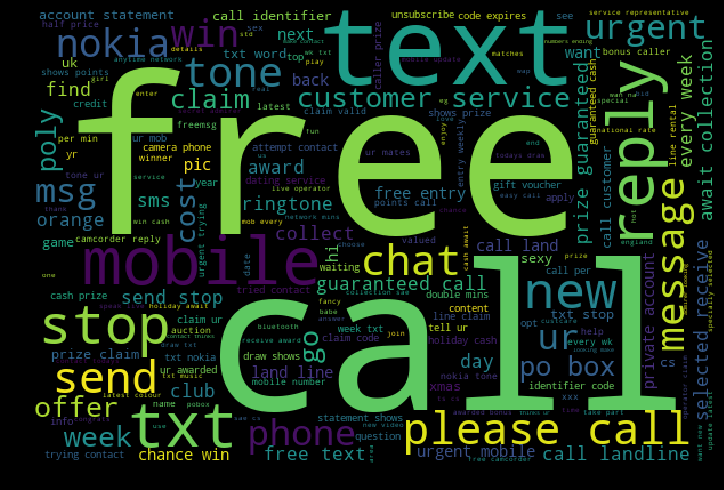

In [18]:
#spam word cloud

spam_wordcloud = WordCloud(width=600, height=400).generate(" ".join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

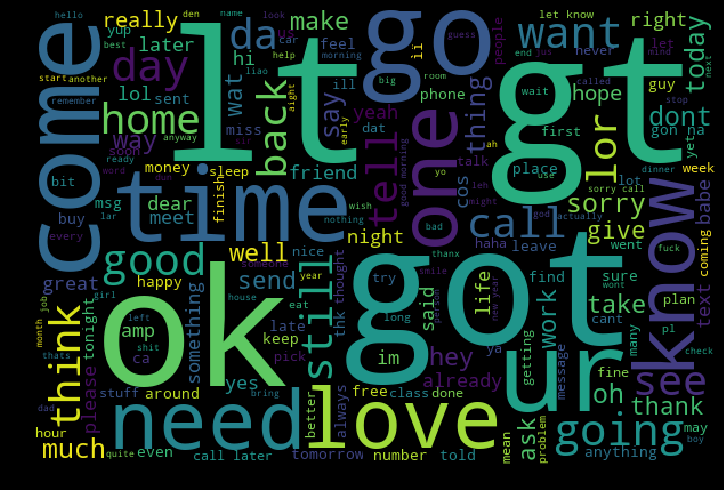

In [19]:
#ham word cloud


ham_wordcloud = WordCloud(width=600, height=400).generate(" ".join(ham_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Checking value_count of maximum used word in spam and ham messages.

In [20]:
#now we see top 10 spam words

spam_words = np.array(spam_words)
print("Top 10 Spam words are :\n")
pd.Series(spam_words).value_counts().head(n = 10)       #giving maximum used word count

Top 10 Spam words are :



call      346
free      217
txt       156
ur        144
u         144
mobile    123
text      121
stop      114
claim     113
reply     104
dtype: int64

In [21]:
#top 10 ham words 

ham_words = np.array(ham_words)
print("Top 10 ham words are :\n")
pd.Series(ham_words).value_counts().head(n = 10)

Top 10 ham words are :



u       974
gt      318
lt      316
get     301
go      246
ok      246
got     242
ur      237
know    234
like    231
dtype: int64

In [22]:
print(df.shape)

(5572, 3)


In [23]:
df.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


# Training and Testing the dataset

For training and testing our dataset, Firstly we have to specify the features and labels

In [24]:
labels = df['label']
text = df['message']


In [25]:
#splitting datas into three sets - train , test and validate

X_train, X_remain, y_train, y_remain = train_test_split(text, labels, stratify = labels, random_state=0, test_size=0.3)

X_test, X_val, y_test, y_val = train_test_split(X_remain,y_remain,stratify = y_remain, random_state = 0, test_size = 0.5)

In [26]:
#check the shape of all three datasets

print("Training Data:",X_train.shape,y_train.shape )

print("Testing Data:", X_test.shape,y_test.shape)

print("Validation Data:", X_val.shape,y_val.shape )

Training Data: (3900,) (3900,)
Testing Data: (836,) (836,)
Validation Data: (836,) (836,)


Doing that requires essentially three steps, in the bag-of-words model:

    1.counting how many times does a word occur in each message (term frequency)
    2.weighting the counts, so that frequent tokens get lower weight (inverse document frequency)
    3.normalizing the vectors to unit length, to abstract from the original text length (L2 norm)



In [27]:
# create the transform
count_vec = CountVectorizer(stop_words='english')

# Learn the vocabulary dictionary and return term-document matrix.
X_train_counts = count_vec.fit_transform(X_train)


#Learn vocabulary and idf from training set.
tf_transformer = TfidfTransformer().fit(X_train_counts)

# Learn vocabulary and idf, return term-document matrix.
X_train_transformed = tf_transformer.transform(X_train_counts)

#test data
X_test_counts = count_vec.transform(X_test)
X_test_transformed = tf_transformer.transform(X_test_counts)

#converts classes into integer
labels = LabelEncoder()
y_train_labels_fit = labels.fit(y_train)
y_train_lables_trf = labels.transform(y_train)

# Model Building

Here we are building a model using MultiNomialNB and CalibratedClassifierCV which are a Classifier.

In [28]:
model = MultinomialNB()

clf = model.fit(X_train_transformed,y_train_lables_trf)

calibrated_svc = CalibratedClassifierCV(base_estimator= model,cv = 'prefit')

calibrated_svc.fit(X_train_transformed,y_train_lables_trf)

predictions = calibrated_svc.predict(X_test_transformed)

## Validation and Prediction

 Here we are predicting the various score.

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: ', format(accuracy_score(labels.transform(y_test), predictions)))
print('Precision score: ', format(precision_score(labels.transform(y_test), predictions)))
print('Recall score: ', format(recall_score(labels.transform(y_test), predictions)))
print('F1 score: ', format(f1_score(labels.transform(y_test), predictions)))

Accuracy score:  0.9748803827751196
Precision score:  0.941747572815534
Recall score:  0.8660714285714286
F1 score:  0.9023255813953488


# Deployment

And finally we are dumping the weights,vocab and tfidf as sav file using pickle.

In [30]:
weights = 'spam_detection_mnb.sav'
pickle.dump(calibrated_svc,open(weights,'wb'))

vocab = 'vocabulary_mnb.sav'
pickle.dump(count_vec, open(vocab, 'wb'))

tfidf = 'tfidf_mnb.sav'
pickle.dump(tf_transformer,open(tfidf,'wb'))